In [325]:
import pandas as pd
import yfinance as yf
import numpy as np

In [326]:
today_date = datetime.today().strftime('%Y-%m-%d')
vix_df = get_historical_data('META', '2017-07-01', today_date)

[*********************100%%**********************]  1 of 1 completed


In [327]:
vix_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-09,356.399994,360.640015,355.359985,357.429993,357.429993,13463900
2024-01-10,360.170013,372.940002,359.079987,370.470001,370.470001,22117200
2024-01-11,372.130005,372.779999,362.929993,369.670013,369.670013,17205400
2024-01-12,370.160004,377.059998,369.540009,374.489990,374.489990,19295700
2024-01-16,373.649994,375.609985,367.230011,367.459991,367.459991,15292200


In [114]:
# Fetch historical price data for TSLA from Yahoo Finance
def get_historical_data(symbol, start_date, end_date):
    tsla_data = yf.download(symbol, start=start_date, end=end_date)
    return tsla_data

# Calculate RSI
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, short_period=12, long_period=26, signal_period=9):
    # Calculate the short-term EMA (Exponential Moving Average)
    short_ema = prices.ewm(span=short_period, adjust=False).mean()
    
    # Calculate the long-term EMA (Exponential Moving Average)
    long_ema = prices.ewm(span=long_period, adjust=False).mean()
    
    # Calculate the MACD line
    macd_line = short_ema - long_ema
    
    # Calculate the Signal line (EMA of MACD)
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    
    # Calculate the MACD Histogram
    macd_histogram = macd_line - signal_line
    
    return macd_line, signal_line, macd_histogram

In [269]:
def create_pnl_column(df, days=1):
    # Ensure days is a positive integer
    if not isinstance(days, int) or days <= 0:
        raise ValueError("Days parameter must be a positive integer")

    # Shift the 'Close' column by 'days' to compare with current 'Close'
    shifted_close = df['Close'].shift(-days)

    # Create 'PnL' column: 1 if Close is higher after 'days', 0 otherwise
    df['PnL'] = np.where(shifted_close > df['Close'], 1, 0)

    #Remove the last five rows
    df = df.iloc[:-1]

In [270]:
# Function to analyze multiple stocks
def analyze_stocks(stock_symbols, start_date, end_date, training_set_sizes, days=5):
    accuracy_results = {}
    profit_results = {}
    predictions = {}

    for symbol in stock_symbols:
        stock_data = get_historical_data(symbol, start_date, end_date)
        rsi_values = calculate_rsi(stock_data['Close'])
        stock_data['RSI'] = rsi_values
        macd_line, signal_line, macd_histogram = calculate_macd(stock_data['Close'])
        stock_data['MACD'] = macd_line
        stock_data.dropna(inplace=True)

        # Create 5-day and 10-day moving averages for 'Close', 'Volume', and 'RSI'
        stock_data['Close_5MA'] = stock_data['Close'].rolling(window=5).mean()
        stock_data['Close_10MA'] = stock_data['Close'].rolling(window=10).mean()
        stock_data['Volume_5MA'] = stock_data['Volume'].rolling(window=5).mean()
        stock_data['Volume_10MA'] = stock_data['Volume'].rolling(window=10).mean()
        stock_data['RSI_5MA'] = stock_data['RSI'].rolling(window=5).mean()
        stock_data['RSI_10MA'] = stock_data['RSI'].rolling(window=10).mean()

        # Create 5-day lagging values for 'Close', 'Volume', and 'RSI'
        stock_data['Close_Lag_5'] = stock_data['Close'].shift(5)
        stock_data['Volume_Lag_5'] = stock_data['Volume'].shift(5)
        stock_data['RSI_Lag_5'] = stock_data['RSI'].shift(5)

        accuracy_values = []
        profits = []  
        pred_values = []
        stock_data.dropna(inplace=True)

        for training_size in training_set_sizes:
            create_pnl_column(stock_data, days)
            train_df = stock_data.iloc[:training_size]

            X = train_df.drop(columns=['High', 'Low', 'Adj Close', 'PnL'])
            y = train_df['PnL']

            split_index = len(X) - 1
            X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
            y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

            model = RandomForestClassifier(random_state=42)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            pred_values.append(y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_values.append(accuracy)

            if y_pred[0] == 1:
                profit = stock_data['Close'].iloc[split_index + 1] - stock_data['Open'].iloc[split_index + 1]
            else:
                profit = 0

            profits.append(profit)

        total_profit = sum(profits)
        accuracy_results[symbol] = accuracy_values
        profit_results[symbol] = total_profit
        predictions[symbol] = pred_values

    return accuracy_results, profit_results, predictions

In [332]:
#Get stock symbols 
tradingview_df = pd.read_csv("/Users/kevinli/Downloads/Stock Screen 114_2024-01-17.csv")
tradingview_df.head()

,Symbol,Description,Price,Price - Currency,Price Change % 1 day,Volume 1 day,Relative Volume 1 day,Market capitalization,Market capitalization - Currency,Price to earnings ratio,"EPS diluted, Trailing 12 months","EPS diluted, Trailing 12 months - Currency","EPS diluted growth %, TTM YoY","Dividend yield %, Trailing 12 months",Sector,Analyst Rating
0,ABBV,AbbVie Inc.,162.835,USD,0.839113,955641,0.164985,2.874913e+11,USD,44.567151,3.6537,USD,-51.30412763,3.66609,Health Technology,Buy
1,ACN,Accenture plc,354.570,USD,0.002820,312229,0.148426,2.223125e+11,USD,32.857937,10.7910,USD,-1.99355161,1.31148,Technology Services,Buy
2,ADBE,Adobe Inc.,585.160,USD,-2.094766,500934,0.226092,2.664233e+11,USD,49.510530,11.8189,USD,17.00143543,0.00000,Technology Services,Buy
3,AKAM,"Akamai Technologies, Inc.",118.000,USD,-0.396725,111179,0.105673,1.779812e+10,USD,35.594703,3.3151,USD,6.23277575,0.00000,Technology Services,Buy
4,AMGN,Amgen Inc.,303.150,USD,-0.108739,322258,0.127200,1.622392e+11,USD,21.557487,14.0624,USD,12.71922793,2.80743,Health Technology,Buy


In [333]:
stock_symbols = tradingview_df['Symbol'].tolist()

In [283]:
# Define the date range
start_date = '2017-07-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Define the list of training set sizes
training_set_sizes = list(range(1400, 1500, 1))

In [284]:
# Analyze multiple stocks
accuracy_results, profit_results, y_pred = analyze_stocks(stock_symbols, start_date, end_date, training_set_sizes)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


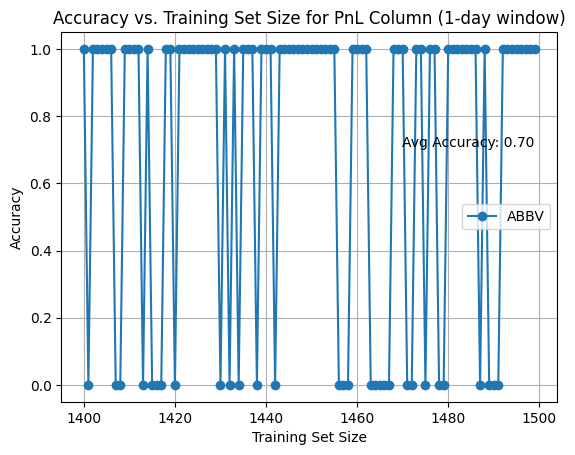

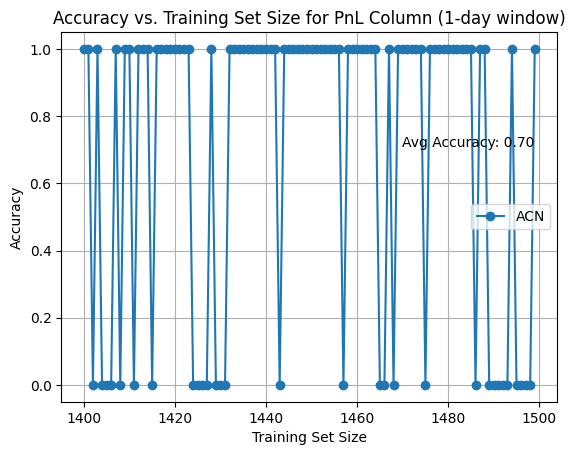

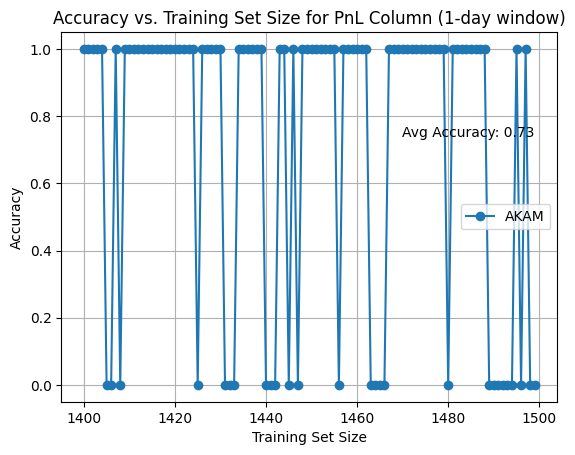

In [286]:
# Plot accuracy results for each stock
for symbol, accuracy_values in accuracy_results.items():
    plt.plot(training_set_sizes, accuracy_values, marker='o', label=symbol)
    avg_accuracy = sum(accuracy_values) / len(accuracy_values)

    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Training Set Size for PnL Column (1-day window)')
    plt.legend()
    plt.grid(True)
    plt.text(training_set_sizes[-1], avg_accuracy, f'Avg Accuracy: {avg_accuracy:.2f}', ha='right', va='bottom')

    plt.show()

In [287]:
# Display profit results for each stock
for symbol, profit in profit_results.items():
    print(f"Total Profit for {symbol}: {profit}")

Total Profit for ABBV: 25.880050659179688
Total Profit for ACN: 71.20001220703125
Total Profit for AKAM: 19.900047302246094


### Last 30 Day Results and Profit

In [330]:
# Function to analyze multiple stocks
def analyze_stocks_actual(stock_symbols, start_date, end_date, days=5):
    accuracy_results = {}
    profit_results = {}
    predictions = {}

    for symbol in stock_symbols:
        stock_data = get_historical_data(symbol, start_date, end_date)
        rsi_values = calculate_rsi(stock_data['Close'])
        stock_data['RSI'] = rsi_values
        macd_line, signal_line, macd_histogram = calculate_macd(stock_data['Close'])
        stock_data['MACD'] = macd_line
        stock_data.dropna(inplace=True)

        # Create 5-day and 10-day moving averages for 'Close', 'Volume', and 'RSI'
        stock_data['Close_5MA'] = stock_data['Close'].rolling(window=5).mean()
        stock_data['Close_10MA'] = stock_data['Close'].rolling(window=10).mean()
        stock_data['Volume_5MA'] = stock_data['Volume'].rolling(window=5).mean()
        stock_data['Volume_10MA'] = stock_data['Volume'].rolling(window=10).mean()
        stock_data['RSI_5MA'] = stock_data['RSI'].rolling(window=5).mean()
        stock_data['RSI_10MA'] = stock_data['RSI'].rolling(window=10).mean()

        # Create 5-day lagging values for 'Close', 'Volume', and 'RSI'
        stock_data['Close_Lag_5'] = stock_data['Close'].shift(5)
        stock_data['Volume_Lag_5'] = stock_data['Volume'].shift(5)
        stock_data['RSI_Lag_5'] = stock_data['RSI'].shift(5)

        accuracy_values = []
        profits = []  
        pred_values = []
        stock_data.dropna(inplace=True)
     
        training_set_sizes = list(range(len(stock_data) - 30, len(stock_data), 1))
        for training_size in training_set_sizes:
            create_pnl_column(stock_data, days = 1)
            train_df = stock_data.iloc[:training_size]
    
            X = train_df.drop(columns=['High', 'Low', 'Adj Close', 'PnL'])
            y = train_df['PnL']

            split_index = len(X) - 1
            X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
         
            y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

            model = RandomForestClassifier(random_state=42)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            pred_values.append(y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_values.append(accuracy)

            if y_pred[0] == 1:
                profit = stock_data['Close'].iloc[split_index + 1] - stock_data['Open'].iloc[split_index + 1]
            else:
                profit = 0

            profits.append(profit)

        total_profit = sum(profits)
        accuracy_results[symbol] = accuracy_values
        profit_results[symbol] = total_profit
        predictions[symbol] = pred_values

    return accuracy_results, profit_results

In [331]:
stock_symbols_actual = ['MSCI', 'META']
analyze_stocks_actual(stock_symbols[3:13], start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


({'AMGN': [1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0],
  'BR': [0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0],
  'CDW': [1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0],
  'CI': [1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0],
  'CNC': 

In [309]:
analyze_stocks_actual(stock_symbols[14:25], start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


({'GOOG': [0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0],
  'GOOGL': [0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0],
  'HCA': [1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0],
  'IBM': [1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0],
  'IQ

## Actual Predictions

In [315]:
# Function to analyze multiple stocks
def analyze_stocks_actualpred(stock_symbols, start_date, end_date, days=1):

    predictions = {}

    for symbol in stock_symbols:
        stock_data = get_historical_data(symbol, start_date, end_date)
        rsi_values = calculate_rsi(stock_data['Close'])
        stock_data['RSI'] = rsi_values
        macd_line, signal_line, macd_histogram = calculate_macd(stock_data['Close'])
        stock_data['MACD'] = macd_line
        stock_data.dropna(inplace=True)

        # Create 5-day and 10-day moving averages for 'Close', 'Volume', and 'RSI'
        stock_data['Close_5MA'] = stock_data['Close'].rolling(window=5).mean()
        stock_data['Close_10MA'] = stock_data['Close'].rolling(window=10).mean()
        stock_data['Volume_5MA'] = stock_data['Volume'].rolling(window=5).mean()
        stock_data['Volume_10MA'] = stock_data['Volume'].rolling(window=10).mean()
        stock_data['RSI_5MA'] = stock_data['RSI'].rolling(window=5).mean()
        stock_data['RSI_10MA'] = stock_data['RSI'].rolling(window=10).mean()

        # Create 5-day lagging values for 'Close', 'Volume', and 'RSI'
        stock_data['Close_Lag_5'] = stock_data['Close'].shift(5)
        stock_data['Volume_Lag_5'] = stock_data['Volume'].shift(5)
        stock_data['RSI_Lag_5'] = stock_data['RSI'].shift(5)

        accuracy_values = []
        profits = []  
        pred_values = []
        stock_data.dropna(inplace=True)
     
  
        create_pnl_column(stock_data, days = 1)
        train_df = stock_data
    
        X = train_df.drop(columns=['High', 'Low', 'Adj Close', 'PnL'])
        y = train_df['PnL']

        split_index = len(X) - 1
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
         
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        model = RandomForestClassifier(random_state=42)
        
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        pred_df = pd.DataFrame({'Symbol': [symbol] * len(y_pred), 'y_pred': y_pred})
        predictions[symbol] = pred_df
    result_df = pd.concat(predictions, ignore_index=True)
    return result_df

In [334]:
analyze_stocks_actualpred(stock_symbols, start_date, end_date, days=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Symbol,y_pred
0,ABBV,0
1,ACN,0
2,ADBE,1
3,AKAM,1
4,AMGN,1
5,BR,0
6,CDW,1
7,CI,1
8,CNC,0
9,CTSH,0


How about the stocks yesterday? 

In [411]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

In [3]:
df = yf.download('VIXY', start='2023-07-01', end='2023-11-01')

[*********************100%%**********************]  1 of 1 completed


In [412]:
# Scaling additional features
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = StandardScaler()  # StandardScaler is often more suitable for features with different scales
df_scaled = scaler.fit_transform(df[features_to_scale])
df_scaled = pd.DataFrame(df_scaled, columns=features_to_scale)
df_scaled

,Open,High,Low,Close,Volume
0,0.653194,0.392318,1.017977,0.591974,-1.967004
1,0.875737,0.479699,1.096365,0.879333,-1.502781
2,1.603514,2.473094,2.050095,1.675557,1.010325
3,1.874174,1.358978,1.540568,1.316358,-0.735306
4,1.368942,1.036758,1.618958,1.190639,-0.943087
...,...,...,...,...,...
80,0.442680,1.145985,0.835070,1.304385,0.171057
81,1.344882,1.375362,1.540568,1.448065,0.422953
82,1.128353,1.511896,1.396856,1.956930,0.573880
83,1.350897,0.889301,1.168222,0.777560,-0.546309


In [424]:
# Set the number of days used for prediction
prediction_days = 20

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(df_scaled)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(df_scaled.iloc[x - prediction_days:x, :].values)
    # Append the current value to y_train
    y_train.append(df_scaled.iloc[x, 0])

In [425]:
# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],  len(features_to_scale)))

In [426]:
x_train, y_train = torch.tensor(x_train).float(), torch.tensor(y_train).float()

In [384]:
df_test = yf.download('VIXY', start='2023-11-01', end='2023-12-30')


df_scaled_test = scaler.fit_transform(df_test[features_to_scale])
df_scaled_test = pd.DataFrame(df_scaled_test, columns=features_to_scale)


# Iterate through the scaled data, starting from the prediction_days index
x_test = [] 

for x in range(prediction_days , len(scaled_data_test)) :
    # Append the previous 'prediction_days' values to x_train
    x_test.append(scaled_data[x - prediction_days : x, :].values)

[*********************100%%**********************]  1 of 1 completed


In [427]:
# Convert the x_train and y_train lists to numpy arrays
x_test = np.array(x_test)

In [428]:
# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [429]:
x_test = torch.tensor(x_test).float()

In [430]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, dropout_rate=0.2):
    
        super(LSTMModel, self).__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_size=num_features, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout_rate if num_layers > 1 else 0)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Forward pass through the LSTM model.
        :param x: Input data
        :return: Model output
        """
        # Pass the input through the LSTM layers
        out, _ = self.lstm(x)
        # Apply dropout
        out = self.dropout(out)
        # Pass the output of the last time step through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

num_features = 5  
hidden_size = 64  # Example size, adjust based on your needs
num_layers = 1    # Adjust based on your model's complexity

model = LSTMModel(num_features, hidden_size, num_layers)


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    outputs = model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Set the model to evaluation mode
model.eval()

Epoch [1/50], Loss: 1.1263
Epoch [2/50], Loss: 1.1235
Epoch [3/50], Loss: 1.1183
Epoch [4/50], Loss: 1.1166
Epoch [5/50], Loss: 1.1174
Epoch [6/50], Loss: 1.1174
Epoch [7/50], Loss: 1.1170
Epoch [8/50], Loss: 1.1165
Epoch [9/50], Loss: 1.1162
Epoch [10/50], Loss: 1.1165
Epoch [11/50], Loss: 1.1167
Epoch [12/50], Loss: 1.1165
Epoch [13/50], Loss: 1.1165
Epoch [14/50], Loss: 1.1164
Epoch [15/50], Loss: 1.1161
Epoch [16/50], Loss: 1.1161
Epoch [17/50], Loss: 1.1163
Epoch [18/50], Loss: 1.1164
Epoch [19/50], Loss: 1.1164
Epoch [20/50], Loss: 1.1164
Epoch [21/50], Loss: 1.1162
Epoch [22/50], Loss: 1.1160
Epoch [23/50], Loss: 1.1160
Epoch [24/50], Loss: 1.1160
Epoch [25/50], Loss: 1.1160
Epoch [26/50], Loss: 1.1161
Epoch [27/50], Loss: 1.1161
Epoch [28/50], Loss: 1.1161
Epoch [29/50], Loss: 1.1161
Epoch [30/50], Loss: 1.1160
Epoch [31/50], Loss: 1.1160
Epoch [32/50], Loss: 1.1159
Epoch [33/50], Loss: 1.1159
Epoch [34/50], Loss: 1.1160
Epoch [35/50], Loss: 1.1160
Epoch [36/50], Loss: 1.1161
E

LSTMModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [431]:
# Make predictions on the test data
with torch.no_grad():
    test_predictions = model(x_test)

test_predictions

tensor([[-0.0864],
        [-0.0863],
        [-0.0859],
        [-0.0853],
        [-0.0860],
        [-0.0857],
        [-0.0856],
        [-0.0859],
        [-0.0862],
        [-0.0857],
        [-0.0860],
        [-0.0862],
        [-0.0858],
        [-0.0858],
        [-0.0848],
        [-0.0856],
        [-0.0860],
        [-0.0859],
        [-0.0862],
        [-0.0858],
        [-0.0862]])

In [396]:
df_test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-01,23.250000,23.250000,22.309999,22.400000,22.400000,3767700
2023-11-02,21.910000,22.270000,21.629999,21.660000,21.660000,2356700
2023-11-03,21.309999,21.420000,21.000000,21.150000,21.150000,2040900
2023-11-06,20.900000,21.059999,20.430000,20.450001,20.450001,2842600
2023-11-07,20.420000,20.610001,20.219999,20.340000,20.340000,2949200
2023-11-08,20.100000,20.590000,19.889999,19.980000,19.980000,3034200
2023-11-09,19.770000,20.940001,19.719999,20.770000,20.770000,4911200
2023-11-10,20.410000,20.420000,19.719999,19.879999,19.879999,4421500
2023-11-13,20.020000,20.139999,19.490000,19.730000,19.730000,3445500


In [403]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

# Download the data
df = yf.download('VIXY', start='2023-07-01', end='2023-11-01')

# Normalize the 'Open' column
scaler = MinMaxScaler()
df['Open'] = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

# Set the number of days used for prediction
prediction_days = 20

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(df['Open'])):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(df['Open'][x - prediction_days:x])
    # Append the current value to y_train
    y_train.append(df['Open'][x])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Convert to PyTorch tensors
x_train, y_train = torch.tensor(x_train).float(), torch.tensor(y_train).float()


[*********************100%%**********************]  1 of 1 completed


/var/folders/0n/jt9yc0v96tg4w5vx0mvqft540000gn/T/ipykernel_82742/1574328128.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train.append(df['Open'][x])


In [406]:
# Create the CNN model
class CNNModel(nn.Module):
    def __init__(self, input_channels, num_filters, kernel_size, output_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, num_filters, kernel_size)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(num_filters * (prediction_days - kernel_size + 1), output_dim)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

# Initialize and train the CNN model
input_channels = 1  # Adjust the number of input channels to 1
num_filters = 32
kernel_size = 3
output_dim = 1  # Output dimension is 1 for regression

model = CNNModel(input_channels, num_filters, kernel_size, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

[*********************100%%**********************]  1 of 1 completed


/var/folders/0n/jt9yc0v96tg4w5vx0mvqft540000gn/T/ipykernel_82742/2465861980.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train.append(df['Open'][x])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [ ]:
%pip uninstall tensorflow

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Would remove:
    /Users/kevinli/miniconda3/bin/estimator_ckpt_converter
    /Users/kevinli/miniconda3/bin/import_pb_to_tensorboard
    /Users/kevinli/miniconda3/bin/saved_model_cli
    /Users/kevinli/miniconda3/bin/tensorboard
    /Users/kevinli/miniconda3/bin/tf_upgrade_v2
    /Users/kevinli/miniconda3/bin/tflite_convert
    /Users/kevinli/miniconda3/bin/toco
    /Users/kevinli/miniconda3/bin/toco_from_protos
    /Users/kevinli/miniconda3/lib/python3.10/site-packages/tensorflow-2.11.0.dist-info/*
    /Users/kevinli/miniconda3/lib/python3.10/site-packages/tensorflow/*
Proceed (Y/n)? 

In [ ]:
from tensorflow.keras.models import Sequential